# PET Challenge 2025 — Approach Comparison

## Two Scoring Approaches

| Aspect | Conservation (MSA + Table S6) | ESM PLM (Zero-Shot) |
|--------|-------------------------------|---------------------|
| **Method** | Penalize mutations at conserved positions | ESM2 log-likelihood ratio per mutation |
| **Compute** | CPU-only, ~1 min (MAFFT) | GPU required, ~30 min (ESM2-650M) |
| **Biological prior** | Conservation = function | Evolutionary plausibility |
| **Notebook** | `Conservation_Scoring_Pipeline.ipynb` | `PET_Challenge_2025_Pipeline_v2.ipynb` |
| **Output** | `results/submission_conservation.csv` | `results/submission_zero_shot_v5.csv` |

## Evaluation Strategy

Since ground truth is unavailable before the competition deadline, we evaluate using:

1. **Inter-approach agreement** — Spearman/Kendall correlation, top-K overlap, rank-rank plots
2. **WT vs mutant separation** — Cohen's d, Mann-Whitney AUC (WT should score higher on average)
3. **IsPETase validation** — 10 single-point mutants with experimental delta-Tm (Son 2019)
4. **Score distribution & granularity** — entropy, unique scores, tie-rate (critical for NDCG)
5. **Within-scaffold discrimination** — score variance among mutants of the same WT
6. **Ensemble exploration** — alpha-sweep to find optimal blending

**Competition metric:** NDCG (rank-based) — rank-order quality is what matters most. Tied scores are penalized by NDCG (random tie-breaking degrades ranking quality).

### Methodological Notes

- **IsPETase is NOT one of the 313 challenge scaffolds**, so ESM2 zero-shot scores are unavailable for IsPETase mutants without GPU recomputation. The comparison uses a supervised ML proxy for ESM — see Section 2 for details.
- Conservation produces far fewer unique scores (many tied predictions) — Section 3 analyzes the NDCG implications.


In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import jensenshannon
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
matplotlib.rcParams.update({'font.size': 11, 'figure.dpi': 100})

# Paths — detect project root (works in Colab, VS Code, and local)
if os.path.exists('data/petase_challenge_data'):
    PROJECT_ROOT = os.getcwd()
elif os.path.exists('pet-challenge-2025/data/petase_challenge_data'):
    PROJECT_ROOT = os.path.join(os.getcwd(), 'pet-challenge-2025')
    os.chdir(PROJECT_ROOT)
elif os.path.exists('/content/pet-challenge-2025/data/petase_challenge_data'):
    PROJECT_ROOT = '/content/pet-challenge-2025'
    os.chdir(PROJECT_ROOT)
else:
    raise FileNotFoundError(
        'Cannot find data/petase_challenge_data/. '
        'Run this notebook from the repo root or clone first.'
    )
DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'petase_challenge_data')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')

CONS_CSV   = os.path.join(RESULTS_DIR, 'submission_conservation.csv')
ESM_V4_CSV = os.path.join(RESULTS_DIR, 'submission_zero_shot_v4.csv')
ESM_CSV    = os.path.join(RESULTS_DIR, 'submission_zero_shot_v5.csv')
WT_CSV     = os.path.join(DATA_DIR, 'pet-2025-wildtype-cds.csv')
TEST_CSV   = os.path.join(DATA_DIR, 'predictive-pet-zero-shot-test-2025.csv')
FEAT_CSV   = os.path.join(PROJECT_ROOT, 'data', 'features_matrix.csv')
MUT_CSV    = os.path.join(PROJECT_ROOT, 'data', 'mutations_dataset.csv')

# Target columns (short aliases)
TARGETS = {
    'act1': 'activity_1 (\u03bcmol [TPA]/min\u00b7mg [E])',
    'act2': 'activity_2 (\u03bcmol [TPA]/min\u00b7mg [E])',
    'expr': 'expression (mg/mL)',
}
TARGET_RANGES = {'act1': (0, 5), 'act2': (0, 5), 'expr': (0, 3)}
TARGET_LABELS = {'act1': 'Activity 1 (pH 5.5)', 'act2': 'Activity 2 (pH 9.0)', 'expr': 'Expression'}

print("Approach Comparison Notebook \u2014 PET Challenge 2025")
print(f"Project root: {PROJECT_ROOT}")

Approach Comparison Notebook — PET Challenge 2025
Project root: /home/dodo/Documents/projects/petase/pet-challenge-2025


In [2]:
# --- File existence checks ---
cons_available = os.path.exists(CONS_CSV)
esm_v4_available = os.path.exists(ESM_V4_CSV)
esm_v5_available = os.path.exists(ESM_CSV)
esm_available = esm_v4_available or esm_v5_available  # backward compat flag

print(f"Conservation submission: {'FOUND' if cons_available else 'MISSING'} \u2014 {CONS_CSV}")
print(f"ESM v4 submission:       {'FOUND' if esm_v4_available else 'MISSING'} \u2014 {ESM_V4_CSV}")
print(f"ESM v5 submission:       {'FOUND' if esm_v5_available else 'MISSING'} \u2014 {ESM_CSV}")

if not cons_available:
    raise FileNotFoundError("Conservation submission is required. Run Conservation_Scoring_Pipeline first.")

# --- Load submissions ---
cons = pd.read_csv(CONS_CSV)
print(f"\nConservation: {len(cons)} sequences, columns: {list(cons.columns)}")

submissions = {'Conservation': cons}

if esm_v4_available:
    esm_v4 = pd.read_csv(ESM_V4_CSV)
    print(f"ESM v4:       {len(esm_v4)} sequences, columns: {list(esm_v4.columns)}")
    assert list(cons['sequence']) == list(esm_v4['sequence']), \
        "Sequence order mismatch between Conservation and ESM v4!"
    submissions['ESM v4'] = esm_v4
else:
    esm_v4 = None

if esm_v5_available:
    esm_v5 = pd.read_csv(ESM_CSV)
    print(f"ESM v5:       {len(esm_v5)} sequences, columns: {list(esm_v5.columns)}")
    assert list(cons['sequence']) == list(esm_v5['sequence']), \
        "Sequence order mismatch between Conservation and ESM v5!"
    submissions['ESM v5'] = esm_v5
else:
    esm_v5 = None

# Backward compat: 'esm' points to latest available ESM version
esm = esm_v5 if esm_v5_available else esm_v4

if esm_available:
    print(f"\nSequence order: MATCHED across {len(submissions)} submissions")
else:
    print("\nNo ESM submissions found \u2014 comparison cells will show conservation-only analysis.")
    print("To enable full comparison, copy submission_zero_shot_v4/v5.csv to results/")

print(f"Active submissions: {list(submissions.keys())}")

# --- Load WT sequences for WT/mutant classification ---
wt_df = pd.read_csv(WT_CSV)
wt_set = set(wt_df['Wt AA Sequence'].values)
print(f"\nWT scaffolds loaded: {len(wt_set)}")

is_wt = cons['sequence'].isin(wt_set).values
n_wt = is_wt.sum()
n_mut = (~is_wt).sum()
print(f"Test set: {n_wt} WT sequences, {n_mut} mutant sequences")
print(f"WT fraction: {n_wt/len(cons)*100:.1f}%")

Conservation submission: FOUND — /home/dodo/Documents/projects/petase/pet-challenge-2025/results/submission_conservation.csv
ESM v4 submission:       FOUND — /home/dodo/Documents/projects/petase/pet-challenge-2025/results/submission_zero_shot_v4.csv
ESM v5 submission:       FOUND — /home/dodo/Documents/projects/petase/pet-challenge-2025/results/submission_zero_shot_v5.csv

Conservation: 4988 sequences, columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']
ESM v4:       4988 sequences, columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']
ESM v5:       4988 sequences, columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']

Sequence order: MATCHED across 3 submissions
Active submissions: ['Conservation', 'ESM v4', 'ESM v5']

WT scaffolds loaded: 313
Test set: 314 WT sequences, 4674 mutant seque

## 1. Submission-Level Comparison

Direct comparison of the two approaches on the 4988 test sequences.


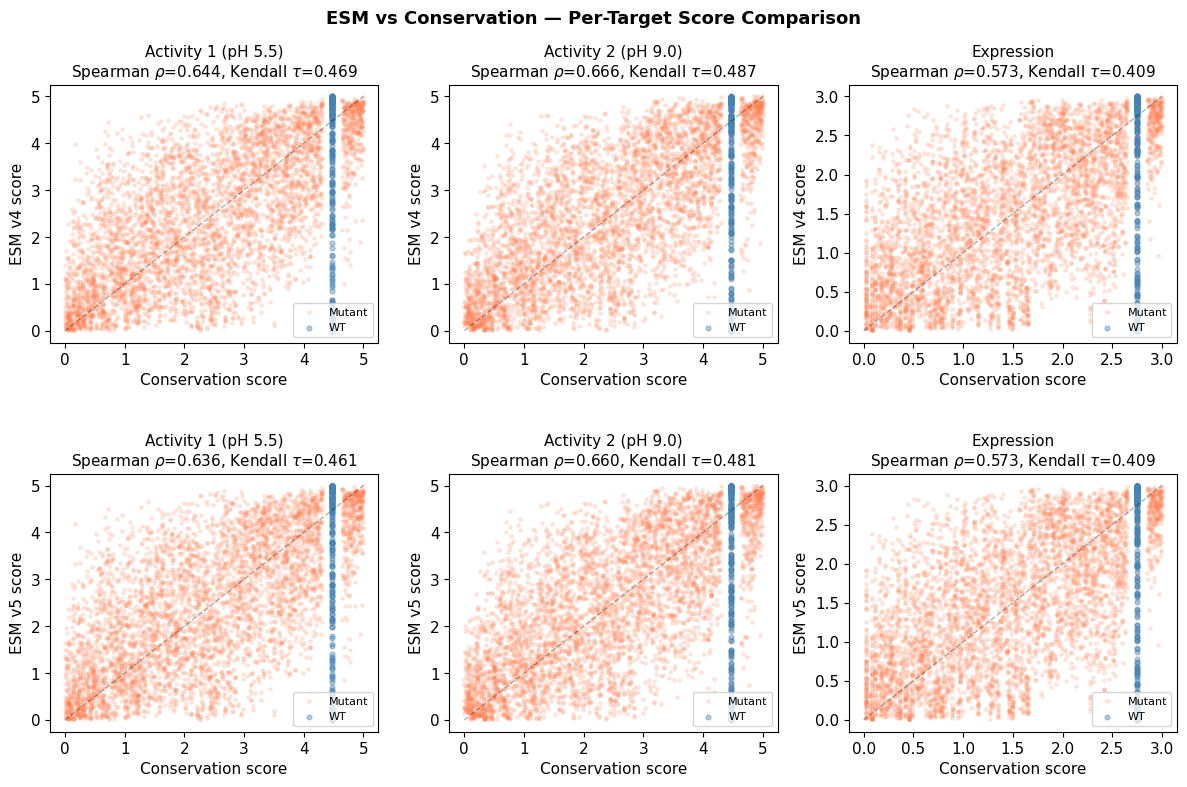

Saved: results/comparison_scatter.png


In [3]:
if not esm_available:
    print("SKIPPING — No ESM submissions available.")
else:
    esm_subs = {k: v for k, v in submissions.items() if k != 'Conservation'}
    n_esm = len(esm_subs)
    fig, axes = plt.subplots(n_esm, 3, figsize=(12, max(7, 4 * n_esm)), squeeze=False)

    for row_idx, (esm_name, esm_df) in enumerate(esm_subs.items()):
        for col_idx, (key, col) in enumerate(TARGETS.items()):
            ax = axes[row_idx, col_idx]
            c_scores = cons[col].values
            e_scores = esm_df[col].values

            ax.scatter(c_scores[~is_wt], e_scores[~is_wt], s=6, alpha=0.15, c='coral', label='Mutant')
            ax.scatter(c_scores[is_wt], e_scores[is_wt], s=12, alpha=0.4, c='steelblue', label='WT')

            lo, hi = TARGET_RANGES[key]
            ax.plot([lo, hi], [lo, hi], 'k--', alpha=0.3, lw=1)

            rho, p_rho = stats.spearmanr(c_scores, e_scores)
            tau, p_tau = stats.kendalltau(c_scores, e_scores)
            ax.set_title(f"{TARGET_LABELS[key]}\nSpearman $\\rho$={rho:.3f}, Kendall $\\tau$={tau:.3f}", fontsize=11)
            ax.set_xlabel('Conservation score')
            ax.set_ylabel(f'{esm_name} score')
            ax.legend(fontsize=8, loc='lower right')

    plt.suptitle('ESM vs Conservation — Per-Target Score Comparison', fontsize=13, fontweight='bold')
    plt.tight_layout(h_pad=3)
    plt.savefig(os.path.join(RESULTS_DIR, 'comparison_scatter.png'), dpi=120, bbox_inches='tight')
    plt.show()
    print("Saved: results/comparison_scatter.png")


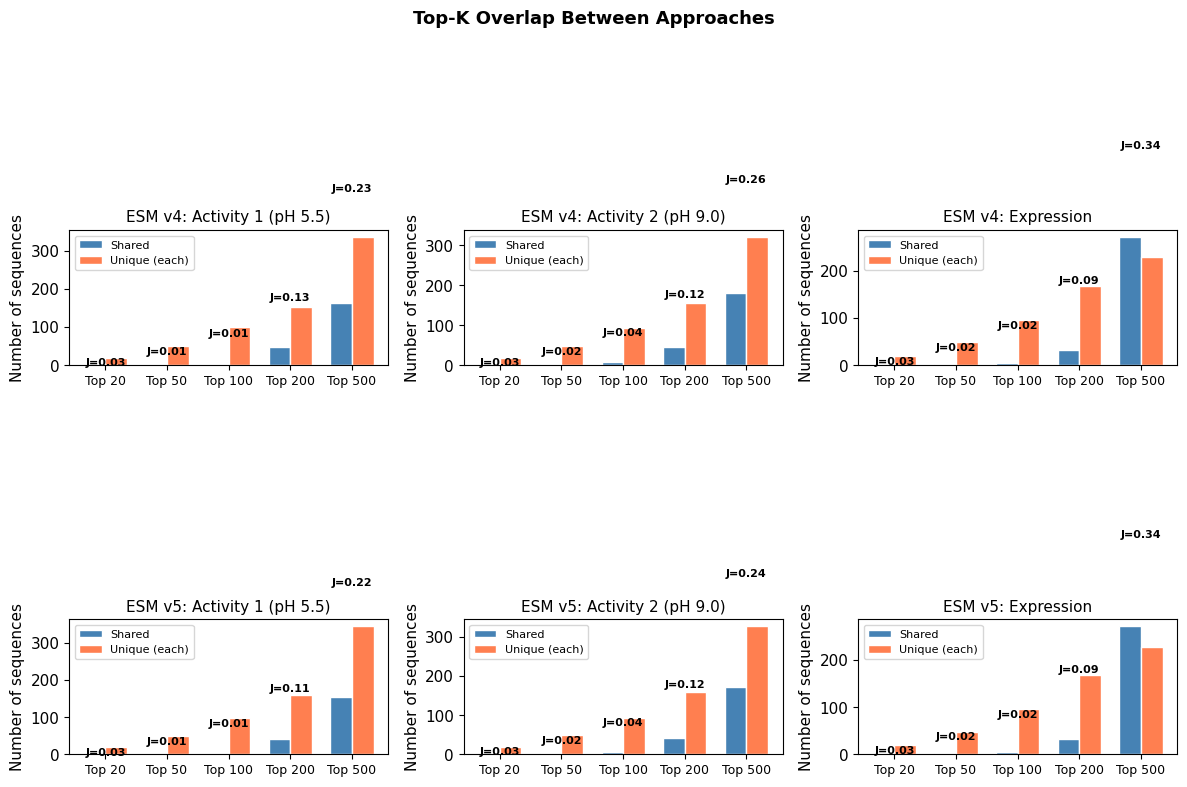

Saved: results/comparison_topk_overlap.png


In [4]:
if not esm_available:
    print("SKIPPING — No ESM submissions available.")
else:
    esm_subs = {k: v for k, v in submissions.items() if k != 'Conservation'}
    K_values = [20, 50, 100, 200, 500]
    n_esm = len(esm_subs)
    fig, axes = plt.subplots(n_esm, 3, figsize=(12, max(7, 4 * n_esm)), squeeze=False)

    for row_idx, (esm_name, esm_df) in enumerate(esm_subs.items()):
        for col_idx, (key, col) in enumerate(TARGETS.items()):
            ax = axes[row_idx, col_idx]
            c_ranks = stats.rankdata(-cons[col].values)
            e_ranks = stats.rankdata(-esm_df[col].values)

            shared_counts = []
            jaccard_vals = []
            for K in K_values:
                c_topk = set(np.where(c_ranks <= K)[0])
                e_topk = set(np.where(e_ranks <= K)[0])
                overlap = len(c_topk & e_topk)
                jaccard = overlap / len(c_topk | e_topk) if len(c_topk | e_topk) > 0 else 0
                shared_counts.append(overlap)
                jaccard_vals.append(jaccard)

            x = np.arange(len(K_values))
            width = 0.35
            ax.bar(x - width/2, shared_counts, width, color='steelblue', edgecolor='white', label='Shared')
            ax.bar(x + width/2, [K - s for K, s in zip(K_values, shared_counts)], width,
                   color='coral', edgecolor='white', label='Unique (each)')

            for i, (j, k) in enumerate(zip(jaccard_vals, K_values)):
                ax.text(i, k * 0.95, f'J={j:.2f}', ha='center', va='top', fontsize=8, fontweight='bold')

            ax.set_xticks(x)
            ax.set_xticklabels([f'Top {K}' for K in K_values], fontsize=9)
            ax.set_ylabel('Number of sequences')
            ax.set_title(f'{esm_name}: {TARGET_LABELS[key]}', fontsize=11)
            ax.legend(fontsize=8, loc='upper left')

    plt.suptitle('Top-K Overlap Between Approaches', fontsize=13, fontweight='bold')
    plt.tight_layout(h_pad=3)
    plt.savefig(os.path.join(RESULTS_DIR, 'comparison_topk_overlap.png'), dpi=120, bbox_inches='tight')
    plt.show()
    print("Saved: results/comparison_topk_overlap.png")


In [5]:
if not esm_available:
    print("SKIPPING \u2014 No ESM submissions available for rank disagreement analysis.")
else:
    # Map each test sequence to its parent WT scaffold
    wt_seqs = list(wt_df['Wt AA Sequence'].values)
    test_seqs = cons['sequence'].values

    def find_parent_wt(seq, wt_list):
        """Find the WT scaffold with highest similarity to seq."""
        if seq in wt_set:
            return seq  # it IS a WT
        best_wt, best_ratio = None, 0
        for wt in wt_list:
            if len(wt) != len(seq):
                continue  # mutations don't change length
            mismatches = sum(1 for a, b in zip(seq, wt) if a != b)
            ratio = 1 - mismatches / len(seq)
            if ratio > best_ratio:
                best_ratio = ratio
                best_wt = wt
        return best_wt

    # Build scaffold map
    print("Mapping test sequences to parent WT scaffolds...")
    parent_wt = []
    for seq in test_seqs:
        parent_wt.append(find_parent_wt(seq, wt_seqs))

    cons_work = cons.copy()
    cons_work['parent_wt'] = parent_wt

    # Count sequences per scaffold (only scaffolds with mutants)
    scaffold_counts = cons_work[~is_wt].groupby('parent_wt').size()
    top_scaffolds = scaffold_counts.nlargest(3).index.tolist()
    print(f"\nTop 3 scaffolds by mutant count: {[f'...{s[-20:]}' for s in top_scaffolds]}")
    print(f"  Mutant counts: {scaffold_counts.nlargest(3).values}")

    # For each top scaffold, compute within-scaffold rank disagreement
    esm_label = 'ESM v5' if esm_v5_available else 'ESM v4'
    for scaffold_idx, scaffold_wt in enumerate(top_scaffolds):
        mask = (cons_work['parent_wt'] == scaffold_wt) & (~is_wt)
        n_muts = mask.sum()
        scaffold_short = f"Scaffold {scaffold_idx + 1} ({n_muts} mutants)"
        print(f"\n{'='*70}")
        print(f"{scaffold_short}")
        print(f"{'='*70}")

        for key, col in TARGETS.items():
            c_scores = cons[col].values[mask]
            e_scores = esm[col].values[mask]

            # Within-scaffold ranks (1 = best)
            c_ranks = stats.rankdata(-c_scores)
            e_ranks = stats.rankdata(-e_scores)
            rank_diff = np.abs(c_ranks - e_ranks)

            # Build disagreement table
            idx_arr = np.where(mask)[0]
            disagree_df = pd.DataFrame({
                'seq_idx': idx_arr,
                'cons_rank': c_ranks.astype(int),
                f'{esm_label}_rank': e_ranks.astype(int),
                'rank_diff': rank_diff.astype(int),
                'cons_score': c_scores,
                f'{esm_label}_score': e_scores,
            })
            disagree_df = disagree_df.sort_values('rank_diff', ascending=False).head(10)

            print(f"\n  {TARGET_LABELS[key]} \u2014 Top-10 rank disagreements (of {n_muts}):")
            print(f"  {'seq_idx':>8} {'cons_rank':>10} {esm_label+'_rank':>10} {'|diff|':>7} {'cons_score':>11} {esm_label+'_score':>11}")
            print(f"  {'-'*65}")
            for _, row in disagree_df.iterrows():
                print(f"  {int(row['seq_idx']):>8} {int(row['cons_rank']):>10} "
                      f"{int(row[f'{esm_label}_rank']):>10} {int(row['rank_diff']):>7} "
                      f"{row['cons_score']:>11.4f} {row[f'{esm_label}_score']:>11.4f}")

    print(f"\n(Rank disagreement = |conservation_rank - {esm_label}_rank| within each scaffold)")

Mapping test sequences to parent WT scaffolds...

Top 3 scaffolds by mutant count: ['...PGPSTGLFAPVSASMNTCPF', '...FLCPLMDNTGIRSYQSTCPL', '...FIDPGPRTGITTGVSDYRLG']
  Mutant counts: [1558 1558 1558]

Scaffold 1 (1558 mutants)

  Activity 1 (pH 5.5) — Top-10 rank disagreements (of 1558):
   seq_idx  cons_rank ESM v5_rank  |diff|  cons_score ESM v5_score
  -----------------------------------------------------------------
       232       1308        218    1090      0.7259      3.5161
      1090        419       1501    1081      3.4946      0.1093
      1094        218       1280    1062      4.1097      0.5574
      1302       1424        388    1036      0.4051      2.9396
      1096        419       1444    1024      3.4946      0.2025
      1387       1301        286    1015      0.7409      3.2745
       345        548       1509     960      2.9522      0.0983
      1078        491       1439     947      3.1477      0.2095
      1310       1531        584     947      0.0536     

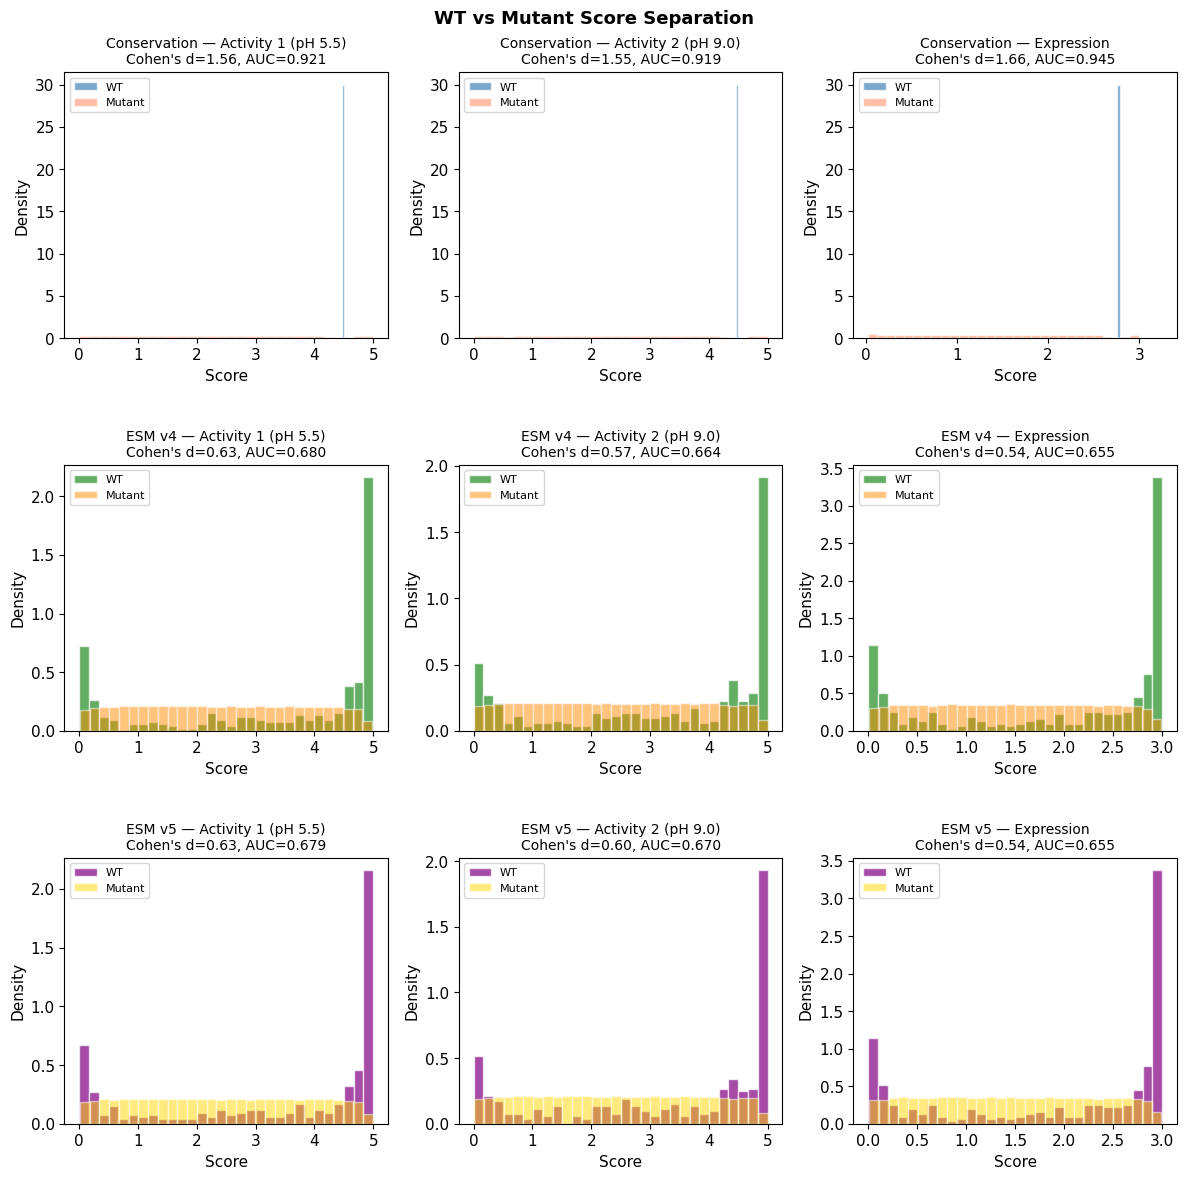


WT/Mutant Separation Statistics:
    Approach              Target  Cohen_d  MW_AUC  WT_mean  Mut_mean
Conservation Activity 1 (pH 5.5)    1.561   0.921    4.475     2.367
Conservation Activity 2 (pH 9.0)    1.550   0.919    4.462     2.368
Conservation          Expression    1.662   0.945    2.751     1.416
      ESM v4 Activity 1 (pH 5.5)    0.631   0.680    3.344     2.443
      ESM v4 Activity 2 (pH 9.0)    0.575   0.664    3.270     2.448
      ESM v4          Expression    0.540   0.655    1.935     1.471
      ESM v5 Activity 1 (pH 5.5)    0.628   0.679    3.340     2.444
      ESM v5 Activity 2 (pH 9.0)    0.595   0.670    3.297     2.446
      ESM v5          Expression    0.540   0.655    1.935     1.471

Saved: results/comparison_wt_separation.png


In [6]:
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std > 0 else 0

def mann_whitney_auc(group1, group2):
    u, _ = stats.mannwhitneyu(group1, group2, alternative='greater')
    return u / (len(group1) * len(group2))

approaches = list(submissions.items())
color_cycle = {'Conservation': ('steelblue', 'coral'),
               'ESM v4': ('forestgreen', 'darkorange'),
               'ESM v5': ('purple', 'gold')}

n_rows = len(approaches)
fig, axes = plt.subplots(n_rows, 3, figsize=(12, max(7, 4 * n_rows)))
if n_rows == 1:
    axes = axes.reshape(1, -1)

sep_stats = []

for row_idx, (name, df) in enumerate(approaches):
    c_wt, c_mut = color_cycle.get(name, ('steelblue', 'coral'))
    for col_idx, (key, col) in enumerate(TARGETS.items()):
        ax = axes[row_idx, col_idx]
        wt_scores = df[col].values[is_wt]
        mut_scores = df[col].values[~is_wt]

        ax.hist(wt_scores, bins=30, alpha=0.7, color=c_wt, edgecolor='white', label='WT', density=True)
        ax.hist(mut_scores, bins=30, alpha=0.5, color=c_mut, edgecolor='white', label='Mutant', density=True)

        d = cohens_d(wt_scores, mut_scores)
        auc = mann_whitney_auc(wt_scores, mut_scores)
        sep_stats.append({'Approach': name, 'Target': TARGET_LABELS[key],
                          'Cohen_d': d, 'MW_AUC': auc,
                          'WT_mean': np.mean(wt_scores), 'Mut_mean': np.mean(mut_scores)})

        ax.set_title(f"{name} — {TARGET_LABELS[key]}\nCohen's d={d:.2f}, AUC={auc:.3f}", fontsize=10)
        ax.set_xlabel('Score')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)

plt.suptitle('WT vs Mutant Score Separation', fontsize=13, fontweight='bold')
plt.tight_layout(h_pad=3)
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_wt_separation.png'), dpi=120, bbox_inches='tight')
plt.show()

sep_df = pd.DataFrame(sep_stats)
print("\nWT/Mutant Separation Statistics:")
print(sep_df.to_string(index=False, float_format='%.3f'))
print("\nSaved: results/comparison_wt_separation.png")


## 1.5 Score Granularity & NDCG Impact

The competition metric is **NDCG** (Normalized Discounted Cumulative Gain), which evaluates ranking quality. When two sequences receive identical predicted scores, their relative order is random — NDCG penalizes this because the evaluator cannot distinguish them.

**Key question:** How many unique scores does each approach produce? A method with massive ties will underperform on NDCG even if its broad ranking is correct.

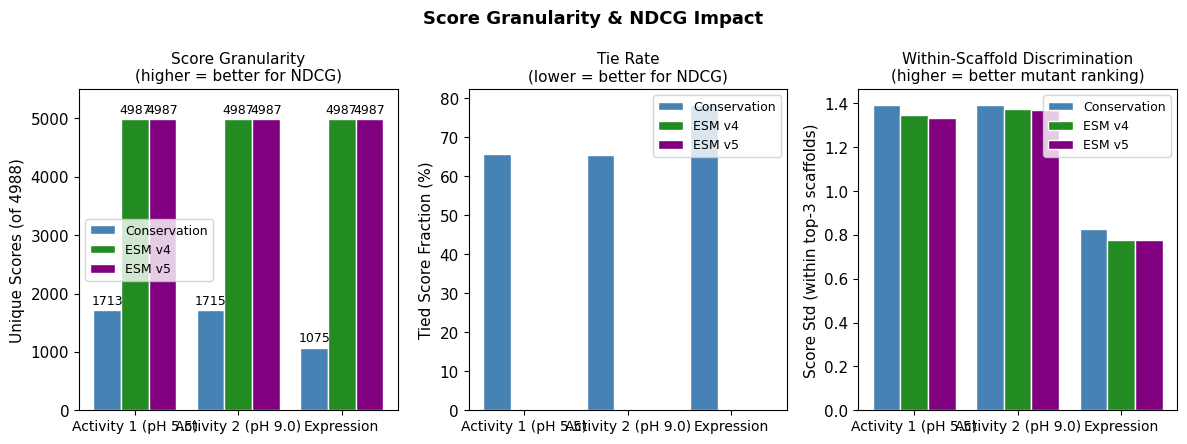


Score Granularity Summary:
    Approach              Target  Total  Unique Scores  Tie Fraction  Within-Scaffold Std
Conservation Activity 1 (pH 5.5)   4988           1713        0.6566               1.3940
Conservation Activity 2 (pH 9.0)   4988           1715        0.6562               1.3953
Conservation          Expression   4988           1075        0.7845               0.8293
      ESM v4 Activity 1 (pH 5.5)   4988           4987        0.0002               1.3471
      ESM v4 Activity 2 (pH 9.0)   4988           4987        0.0002               1.3762
      ESM v4          Expression   4988           4987        0.0002               0.7757
      ESM v5 Activity 1 (pH 5.5)   4988           4987        0.0002               1.3323
      ESM v5 Activity 2 (pH 9.0)   4988           4987        0.0002               1.3700
      ESM v5          Expression   4988           4987        0.0002               0.7757

Conservation's ~1700 unique scores (vs ESM's ~4987) mean ~65% of sequen

In [7]:
# === Score Granularity & NDCG Tie-Rate Analysis ===
from itertools import combinations

granularity_rows = []
for name, df in submissions.items():
    for key, col in TARGETS.items():
        scores = df[col].values
        n_total = len(scores)
        n_unique = len(np.unique(scores))
        tie_fraction = 1.0 - (n_unique / n_total)

        # Within-scaffold analysis: score variance among mutants of top-3 scaffolds
        # (measures whether method can distinguish mutations within same WT)
        esm2_scores_path = os.path.join(RESULTS_DIR, 'esm2_scores.csv')
        if os.path.exists(esm2_scores_path):
            esm2_raw = pd.read_csv(esm2_scores_path)
            wt_idx = esm2_raw['wt_idx'].values
            # Top-3 scaffolds by mutant count
            from collections import Counter
            wt_counts = Counter(wt_idx)
            top3_wts = [w for w, _ in wt_counts.most_common(3)]
            within_stds = []
            for wt in top3_wts:
                mask = (wt_idx == wt) & (esm2_raw['n_mutations'].values > 0)
                if mask.sum() > 1:
                    within_stds.append(np.std(scores[mask]))
            avg_within_std = np.mean(within_stds) if within_stds else 0.0
        else:
            avg_within_std = np.nan

        granularity_rows.append({
            'Approach': name,
            'Target': TARGET_LABELS[key],
            'Total': n_total,
            'Unique Scores': n_unique,
            'Tie Fraction': tie_fraction,
            'Within-Scaffold Std': avg_within_std,
        })

gran_df = pd.DataFrame(granularity_rows)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))

# Panel 1: Unique scores bar chart
approach_names = list(submissions.keys())
x = np.arange(len(TARGETS))
width = 0.8 / len(approach_names)
colors = {'Conservation': 'steelblue', 'ESM v4': 'forestgreen', 'ESM v5': 'purple'}
for i, name in enumerate(approach_names):
    vals = gran_df[gran_df['Approach'] == name]['Unique Scores'].values
    bars = axes[0].bar(x + i * width - 0.4 + width/2, vals, width,
                       color=colors.get(name, 'gray'), label=name, edgecolor='white')
    for bar, v in zip(bars, vals):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                     str(v), ha='center', va='bottom', fontsize=9)
axes[0].set_xticks(x)
axes[0].set_xticklabels([TARGET_LABELS[k] for k in TARGETS], fontsize=10)
axes[0].set_ylabel('Unique Scores (of 4988)')
axes[0].set_title('Score Granularity\n(higher = better for NDCG)', fontsize=11)
axes[0].legend(fontsize=9)
axes[0].set_ylim(0, 5500)

# Panel 2: Tie fraction
for i, name in enumerate(approach_names):
    vals = gran_df[gran_df['Approach'] == name]['Tie Fraction'].values * 100
    axes[1].bar(x + i * width - 0.4 + width/2, vals, width,
                color=colors.get(name, 'gray'), label=name, edgecolor='white')
axes[1].set_xticks(x)
axes[1].set_xticklabels([TARGET_LABELS[k] for k in TARGETS], fontsize=10)
axes[1].set_ylabel('Tied Score Fraction (%)')
axes[1].set_title('Tie Rate\n(lower = better for NDCG)', fontsize=11)
axes[1].legend(fontsize=9)

# Panel 3: Within-scaffold std
for i, name in enumerate(approach_names):
    vals = gran_df[gran_df['Approach'] == name]['Within-Scaffold Std'].values
    axes[2].bar(x + i * width - 0.4 + width/2, vals, width,
                color=colors.get(name, 'gray'), label=name, edgecolor='white')
axes[2].set_xticks(x)
axes[2].set_xticklabels([TARGET_LABELS[k] for k in TARGETS], fontsize=10)
axes[2].set_ylabel('Score Std (within top-3 scaffolds)')
axes[2].set_title('Within-Scaffold Discrimination\n(higher = better mutant ranking)', fontsize=11)
axes[2].legend(fontsize=9)

plt.suptitle('Score Granularity & NDCG Impact', fontsize=13, fontweight='bold')
plt.tight_layout(h_pad=2)
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_granularity.png'), dpi=120, bbox_inches='tight')
plt.show()

print("\nScore Granularity Summary:")
print(gran_df.to_string(index=False, float_format='%.4f'))
print("\nConservation's ~1700 unique scores (vs ESM's ~4987) mean ~65% of sequence pairs share")
print("identical scores. Under NDCG, tied pairs are ranked randomly — significant penalty.")
print("Saved: results/comparison_granularity.png")


## 2. IsPETase Validation

The 10 single-point IsPETase mutants with experimentally measured delta-Tm (Son 2019) provide a small but direct validation set.

**Important constraint:** IsPETase is *not* one of the 313 challenge scaffolds, so these mutants are **not** in the 4988 test set. ESM2 zero-shot delta log-likelihood scores cannot be computed for these mutants without GPU recomputation.

### Comparison Protocol

| Panel | Conservation | ESM |
|-------|-------------|-----|
| **A: Zero-shot** (10 mutants) | Table S6 conservation score vs delta-Tm | *Not available* — IsPETase not in test set |
| **B: Supervised ML proxy** (31 variants, LOOCV) | Ridge on conservation-derived features | Ridge on ESM-derived features |

Panel B uses **identical protocol** (LOOCV Ridge regression) on the **same 31 IsPETase variants** from `features_matrix.csv`, making it a fair apples-to-apples comparison. However, it measures *supervised ML* quality, not zero-shot prediction.


In [8]:
# Table S6 from Buchholz et al. (Proteins, 2022)
# {ispetase_position: (consensus_aa, conservation_frequency_pct)}
TABLE_S6 = {
    32: ("Y", 74), 34: ("R", 84), 35: ("G", 91), 36: ("P", 92),
    38: ("P", 95), 39: ("T", 87), 42: ("S", 73), 45: ("A", 87),
    48: ("G", 97), 49: ("P", 71), 57: ("V", 91), 62: ("G", 93),
    63: ("F", 93), 64: ("G", 83), 65: ("G", 86), 66: ("G", 93),
    67: ("T", 76), 68: ("I", 79), 69: ("Y", 84), 70: ("Y", 91),
    71: ("P", 98), 72: ("T", 85), 74: ("T", 81), 76: ("G", 90),
    77: ("T", 84), 78: ("F", 74), 79: ("G", 90), 80: ("A", 77),
    85: ("P", 99), 86: ("G", 100), 88: ("T", 76), 92: ("S", 70),
    96: ("W", 93), 98: ("G", 89), 99: ("P", 82), 100: ("R", 81),
    101: ("L", 81), 102: ("A", 97), 103: ("S", 96), 105: ("G", 99),
    106: ("F", 97), 107: ("V", 96), 108: ("V", 94), 111: ("I", 84),
    113: ("T", 96), 118: ("D", 98), 120: ("P", 87), 122: ("S", 71),
    123: ("R", 99), 124: ("G", 73), 126: ("Q", 92), 127: ("L", 83),
    128: ("L", 78), 129: ("A", 88), 130: ("A", 96), 131: ("L", 88),
    132: ("D", 82), 133: ("Y", 77), 134: ("L", 85), 138: ("S", 83),
    145: ("V", 82), 146: ("R", 71), 148: ("R", 81), 150: ("D", 94),
    153: ("R", 94), 154: ("L", 85), 156: ("V", 89), 158: ("G", 100),
    159: ("H", 87), 160: ("S", 100), 161: ("M", 94), 162: ("G", 100),
    163: ("G", 99), 164: ("G", 96), 165: ("G", 97), 167: ("L", 88),
    169: ("A", 89), 170: ("A", 82), 173: ("R", 76), 174: ("P", 76),
    176: ("L", 84), 178: ("A", 95), 179: ("A", 78), 181: ("P", 80),
    182: ("L", 79), 184: ("P", 76), 185: ("W", 77), 197: ("P", 97),
    198: ("T", 93), 202: ("G", 75), 206: ("D", 100), 209: ("A", 87),
    211: ("V", 70), 214: ("H", 77), 217: ("P", 79), 218: ("F", 74),
    219: ("Y", 96), 221: ("S", 70), 228: ("A", 77), 229: ("Y", 83),
    231: ("E", 91), 232: ("L", 76), 235: ("A", 76), 237: ("H", 100),
    240: ("P", 74), 244: ("N", 74), 257: ("W", 90), 258: ("L", 80),
    259: ("K", 94), 260: ("R", 78), 261: ("F", 79), 263: ("D", 94),
    265: ("D", 97), 266: ("T", 76), 267: ("R", 96), 268: ("Y", 92),
    270: ("Q", 77), 271: ("F", 96), 272: ("L", 86), 273: ("C", 95),
    274: ("P", 82),
}

# Load mutations dataset — filter single-point IsPETase mutants
mut_df = pd.read_csv(MUT_CSV)
features_df = pd.read_csv(FEAT_CSV)

# Single-point mutants: N_mutations == 1 in features_matrix
single_mask = features_df['N_mutations'] == 1
single_variants = features_df.loc[single_mask, 'variant_name'].values
single_df = mut_df[mut_df['variant_name'].isin(single_variants)].copy()
print(f"Single-point IsPETase mutants: {len(single_df)}")
print(f"Variants: {list(single_df['variant_name'].values)}")

# Parse mutation: e.g. "D186H" -> (pos=186, wt_aa='D', mut_aa='H')
def parse_single_mutation(mut_str):
    wt_aa = mut_str[0]
    mut_aa = mut_str[-1]
    pos = int(mut_str[1:-1])
    return pos, wt_aa, mut_aa

# Conservation score for each mutant
cons_scores = []
for _, row in single_df.iterrows():
    pos, wt_aa, mut_aa = parse_single_mutation(row['mutation'])
    if pos in TABLE_S6:
        consensus_aa, freq_pct = TABLE_S6[pos]
        # Penalty: frequency of consensus (WT) minus estimated frequency of mutant
        # If WT matches consensus, use table freq; otherwise estimate lower
        wt_freq = freq_pct / 100.0 if wt_aa == consensus_aa else (100 - freq_pct) / (19 * 100.0)
        mut_freq = freq_pct / 100.0 if mut_aa == consensus_aa else (100 - freq_pct) / (19 * 100.0)
        score = -(wt_freq - mut_freq)  # negative penalty = less damage to function
    else:
        # Position not conserved (< 70%) — mutation has minimal predicted impact
        score = 0.0
    cons_scores.append(score)

single_df = single_df.copy()
single_df['cons_score'] = cons_scores
single_df['delta_tm'] = single_df['delta_tm'].astype(float)

# Print table
print("\n--- IsPETase Single-Point Mutant Validation ---")
print(f"{'Mutation':<12} {'Pos':>4} {'In S6?':>6} {'Cons Score':>10} {'delta-Tm':>9}")
print("-" * 50)
for _, row in single_df.iterrows():
    pos, wt_aa, mut_aa = parse_single_mutation(row['mutation'])
    in_s6 = 'Yes' if pos in TABLE_S6 else 'No'
    print(f"{row['mutation']:<12} {pos:>4} {in_s6:>6} {row['cons_score']:>10.4f} {row['delta_tm']:>9.2f}")

# Spearman correlation
rho, pval = stats.spearmanr(single_df['cons_score'], single_df['delta_tm'])
print(f"\nSpearman rho = {rho:.3f}, p = {pval:.4f}")
print(f"(Positive rho means: higher conservation score ~ higher delta-Tm — correct direction)")


Single-point IsPETase mutants: 10
Variants: ['D186V', 'D186H', 'D186I', 'D186F', 'D186L', 'P181A', 'S121E', 'S121D', 'P181S', 'P181G']

--- IsPETase Single-Point Mutant Validation ---
Mutation      Pos In S6? Cons Score  delta-Tm
--------------------------------------------------
D186V         186     No     0.0000      4.65
D186H         186     No     0.0000      4.35
D186I         186     No     0.0000      3.89
D186F         186     No     0.0000      3.09
D186L         186     No     0.0000      2.86
P181A         181    Yes    -0.7895      0.44
S121E         121     No     0.0000     -1.13
S121D         121     No     0.0000     -1.46
P181S         181    Yes    -0.7895     -2.89
P181G         181    Yes    -0.7895     -5.02

Spearman rho = 0.646, p = 0.0437
(Positive rho means: higher conservation score ~ higher delta-Tm — correct direction)


=== Fair ML Proxy Comparison (LOOCV Ridge, same 31 variants) ===
  Conservation features (4 cols): rho=0.875, RMSE=4.8C
  ESM features (37 cols):           rho=0.961, RMSE=3.3C


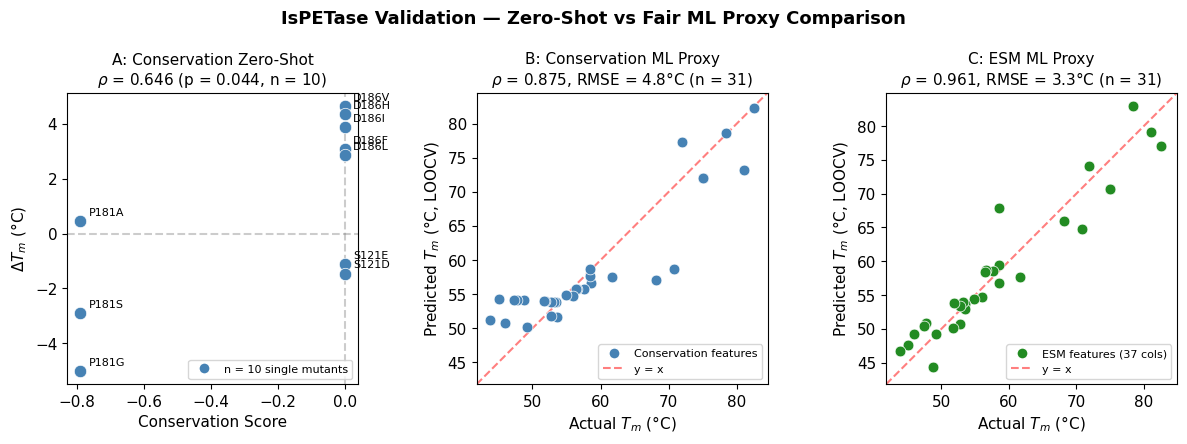

Saved: results/comparison_ispetase_validation.png


In [9]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut

# --- Load features matrix (31 IsPETase variants with Tm) ---
feat_df = pd.read_csv(FEAT_CSV)
all_feature_cols = [c for c in feat_df.columns if c not in ('variant_name', 'Tm')]
X_all = feat_df[all_feature_cols].values
y = feat_df['Tm'].values
names = feat_df['variant_name'].values

# --- Build conservation-derived feature set ---
# For each of the 31 variants, compute conservation features from Table S6
cons_features = []
for _, row in feat_df.iterrows():
    # Look up mutation info from mutations_dataset
    mut_row = mut_df[mut_df['variant_name'] == row['variant_name']]
    if len(mut_row) == 0:
        cons_features.append([0, 0, 0, 0])
        continue
    mut_str = mut_row.iloc[0]['mutation']
    mutations = mut_str.split('/')
    n_at_conserved = 0
    total_penalty = 0.0
    max_penalty = 0.0
    n_muts = len(mutations)
    for m in mutations:
        if len(m) < 3:
            continue
        try:
            pos = int(m[1:-1])
            wt_aa, mut_aa = m[0], m[-1]
        except ValueError:
            continue
        if pos in TABLE_S6:
            consensus_aa, freq_pct = TABLE_S6[pos]
            wt_freq = freq_pct / 100.0 if wt_aa == consensus_aa else (100 - freq_pct) / (19 * 100.0)
            mut_freq = freq_pct / 100.0 if mut_aa == consensus_aa else (100 - freq_pct) / (19 * 100.0)
            penalty = wt_freq - mut_freq
            total_penalty += penalty
            max_penalty = max(max_penalty, abs(penalty))
            n_at_conserved += 1
    cons_features.append([n_muts, n_at_conserved, total_penalty, max_penalty])

X_cons = np.array(cons_features)
cons_feat_names = ['N_mutations', 'N_conserved_positions', 'Total_conservation_penalty', 'Max_conservation_penalty']

# --- LOOCV for BOTH approaches with identical protocol ---
loo = LeaveOneOut()

def loocv_ridge(X, y, alpha=10.0):
    scaler = StandardScaler()
    y_pred = np.zeros(len(y))
    for train_idx, test_idx in loo.split(X):
        X_tr = scaler.fit_transform(X[train_idx])
        X_te = scaler.transform(X[test_idx])
        model = Ridge(alpha=alpha)
        model.fit(X_tr, y[train_idx])
        y_pred[test_idx] = model.predict(X_te)
    return y_pred

# ESM features (all columns from features_matrix)
y_pred_esm = loocv_ridge(X_all, y)
esm_rho, esm_pval = stats.spearmanr(y, y_pred_esm)
esm_rmse = np.sqrt(np.mean((y - y_pred_esm) ** 2))

# Conservation features (4 columns)
y_pred_cons_ml = loocv_ridge(X_cons, y)
cons_ml_rho, cons_ml_pval = stats.spearmanr(y, y_pred_cons_ml)
cons_ml_rmse = np.sqrt(np.mean((y - y_pred_cons_ml) ** 2))

print("=== Fair ML Proxy Comparison (LOOCV Ridge, same 31 variants) ===")
print(f"  Conservation features ({X_cons.shape[1]} cols): rho={cons_ml_rho:.3f}, RMSE={cons_ml_rmse:.1f}C")
print(f"  ESM features ({X_all.shape[1]} cols):           rho={esm_rho:.3f}, RMSE={esm_rmse:.1f}C")

# --- Visualization: 3 panels ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))

# Panel A: Conservation zero-shot (10 single-point mutants)
ax1.scatter(single_df['cons_score'], single_df['delta_tm'],
            s=80, c='steelblue', edgecolors='white', zorder=5, linewidths=0.5)
for _, row in single_df.iterrows():
    ax1.annotate(row['mutation'], (row['cons_score'], row['delta_tm']),
                 fontsize=8, xytext=(6, 4), textcoords='offset points')
ax1.axhline(0, ls='--', color='gray', alpha=0.4)
ax1.axvline(0, ls='--', color='gray', alpha=0.4)
ax1.set_xlabel('Conservation Score')
ax1.set_ylabel('$\\Delta T_m$ ($\\degree$C)')
ax1.set_title(f'A: Conservation Zero-Shot\n$\\rho$ = {rho:.3f} (p = {pval:.3f}, n = {len(single_df)})',
              fontsize=11)
legend1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue',
                  markersize=8, label=f'n = {len(single_df)} single mutants')]
ax1.legend(handles=legend1, fontsize=8, loc='lower right')

# Panel B: Conservation ML proxy (31 variants, LOOCV)
ax2.scatter(y, y_pred_cons_ml, s=60, c='steelblue', edgecolors='white', zorder=5, linewidths=0.5)
lims = [min(y.min(), y_pred_cons_ml.min()) - 2, max(y.max(), y_pred_cons_ml.max()) + 2]
ax2.plot(lims, lims, 'r--', alpha=0.5, lw=1.5)
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel('Actual $T_m$ ($\\degree$C)')
ax2.set_ylabel('Predicted $T_m$ ($\\degree$C, LOOCV)')
ax2.set_title(f'B: Conservation ML Proxy\n$\\rho$ = {cons_ml_rho:.3f}, RMSE = {cons_ml_rmse:.1f}$\\degree$C (n = {len(y)})',
              fontsize=11)
legend2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=8, label='Conservation features'),
           Line2D([0], [0], ls='--', color='r', alpha=0.5, label='y = x')]
ax2.legend(handles=legend2, fontsize=8, loc='lower right')

# Panel C: ESM ML proxy (31 variants, LOOCV) — same protocol as Panel B
ax3.scatter(y, y_pred_esm, s=60, c='forestgreen', edgecolors='white', zorder=5, linewidths=0.5)
lims3 = [min(y.min(), y_pred_esm.min()) - 2, max(y.max(), y_pred_esm.max()) + 2]
ax3.plot(lims3, lims3, 'r--', alpha=0.5, lw=1.5)
ax3.set_xlim(lims3)
ax3.set_ylim(lims3)
ax3.set_xlabel('Actual $T_m$ ($\\degree$C)')
ax3.set_ylabel('Predicted $T_m$ ($\\degree$C, LOOCV)')
ax3.set_title(f'C: ESM ML Proxy\n$\\rho$ = {esm_rho:.3f}, RMSE = {esm_rmse:.1f}$\\degree$C (n = {len(y)})',
              fontsize=11)
legend3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen', markersize=8, label=f'ESM features ({X_all.shape[1]} cols)'),
           Line2D([0], [0], ls='--', color='r', alpha=0.5, label='y = x')]
ax3.legend(handles=legend3, fontsize=8, loc='lower right')

plt.suptitle('IsPETase Validation — Zero-Shot vs Fair ML Proxy Comparison', fontsize=13, fontweight='bold')
plt.tight_layout(w_pad=2)
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_ispetase_validation.png'), dpi=120, bbox_inches='tight')
plt.show()
print("Saved: results/comparison_ispetase_validation.png")


## 3. Score Distribution Analysis

Compare how each approach distributes scores across the 4988 test sequences.
Good ranking requires spread (not all scores clustered together) and discrimination
(different sequences get distinguishably different scores).


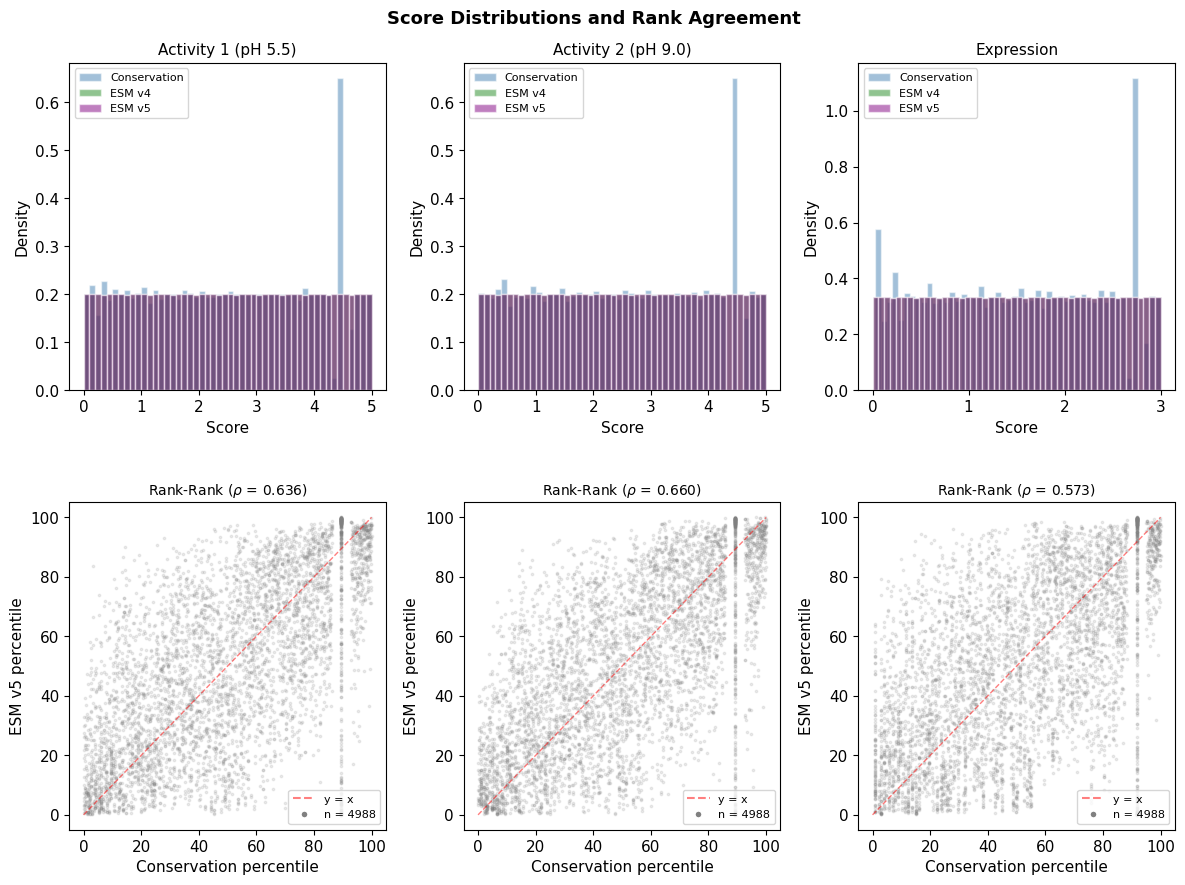


Distribution Statistics:
    Approach              Target  Rank Entropy  Unique Scores    Std    IQR
Conservation Activity 1 (pH 5.5)        0.9830           1713 1.4435 2.4934
      ESM v4 Activity 1 (pH 5.5)        1.0000           4987 1.4437 2.5000
      ESM v5 Activity 1 (pH 5.5)        1.0000           4987 1.4437 2.5000
Conservation Activity 2 (pH 9.0)        0.9812           1715 1.4435 2.5019
      ESM v4 Activity 2 (pH 9.0)        1.0000           4987 1.4437 2.5000
      ESM v5 Activity 2 (pH 9.0)        1.0000           4987 1.4437 2.5000
Conservation          Expression        0.9818           1075 0.8661 1.4955
      ESM v4          Expression        1.0000           4987 0.8662 1.5000
      ESM v5          Expression        1.0000           4987 0.8662 1.5000

Rank entropy = 1.0 means perfectly uniform rank distribution (ideal).
Saved: results/comparison_distributions.png


In [10]:
color_map = {'Conservation': 'steelblue', 'ESM v4': 'forestgreen', 'ESM v5': 'purple'}
approaches_avail = [(k, v, color_map.get(k, 'gray')) for k, v in submissions.items()]

fig, axes = plt.subplots(2, 3, figsize=(12, 9))

entropy_stats = []
for col_idx, (key, col) in enumerate(TARGETS.items()):
    ax_top = axes[0, col_idx]
    ax_bot = axes[1, col_idx]

    for name, df, color in approaches_avail:
        scores = df[col].values

        ax_top.hist(scores, bins=50, alpha=0.5, color=color, edgecolor='white',
                    density=True, label=name)

        ranks = stats.rankdata(scores)
        norm_ranks = ranks / len(ranks)
        hist_counts, _ = np.histogram(norm_ranks, bins=50, range=(0, 1))
        hist_probs = hist_counts / hist_counts.sum()
        hist_probs = hist_probs[hist_probs > 0]
        rank_entropy = stats.entropy(hist_probs) / np.log(50)
        n_unique = len(np.unique(scores))
        entropy_stats.append({'Approach': name, 'Target': TARGET_LABELS[key],
                              'Rank Entropy': rank_entropy, 'Unique Scores': n_unique,
                              'Std': np.std(scores), 'IQR': np.percentile(scores, 75) - np.percentile(scores, 25)})

    ax_top.set_title(TARGET_LABELS[key], fontsize=11)
    ax_top.set_xlabel('Score')
    ax_top.set_ylabel('Density')
    ax_top.legend(fontsize=8)

    # Bottom row: rank-rank percentile plots (Conservation vs latest ESM)
    if esm_available:
        c_pctile = stats.rankdata(cons[col].values) / len(cons) * 100
        e_pctile = stats.rankdata(esm[col].values) / len(esm) * 100
        esm_label = 'ESM v5' if esm_v5_available else 'ESM v4'
        ax_bot.scatter(c_pctile, e_pctile, s=3, alpha=0.15, c='gray')
        ax_bot.plot([0, 100], [0, 100], 'r--', alpha=0.5, lw=1)
        rho_rr, _ = stats.spearmanr(c_pctile, e_pctile)
        ax_bot.set_title(f'Rank-Rank ($\\rho$ = {rho_rr:.3f})', fontsize=10)
        ax_bot.set_xlabel('Conservation percentile')
        ax_bot.set_ylabel(f'{esm_label} percentile')
        legend_rr = [Line2D([0], [0], ls='--', color='r', alpha=0.5, label='y = x'),
                     Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                            markersize=5, label=f'n = {len(cons)}')]
        ax_bot.legend(handles=legend_rr, fontsize=8, loc='lower right')
    else:
        ax_bot.text(0.5, 0.5, 'ESM not available', ha='center', va='center',
                    transform=ax_bot.transAxes, fontsize=12, color='gray')
        ax_bot.set_axis_off()

plt.suptitle('Score Distributions and Rank Agreement', fontsize=13, fontweight='bold')
plt.tight_layout(h_pad=3)
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_distributions.png'), dpi=120, bbox_inches='tight')
plt.show()

ent_df = pd.DataFrame(entropy_stats)
print("\nDistribution Statistics:")
print(ent_df.to_string(index=False, float_format='%.4f'))
print("\nRank entropy = 1.0 means perfectly uniform rank distribution (ideal).")
print("Saved: results/comparison_distributions.png")


## 4. Ensemble Exploration

Blend Conservation and ESM scores:
**ensemble = alpha * Conservation_rank + (1 - alpha) * ESM_rank**

Sweep alpha from 0 (pure ESM) to 1 (pure Conservation) in 51 steps.
Evaluate WT/mutant separation (Cohen's d) and ranking entropy at each alpha.


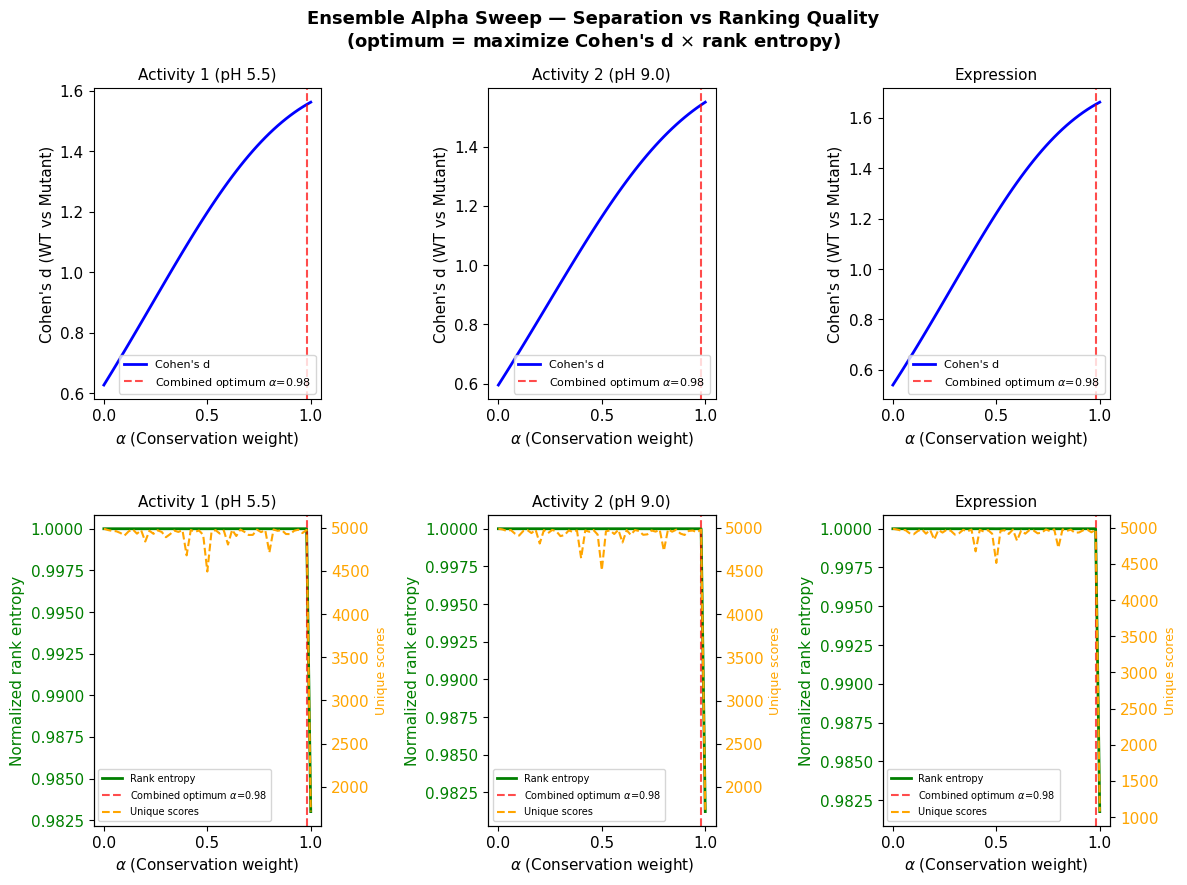


Optimal alpha per target (maximizes Cohen's d x rank entropy):
  Activity 1 (pH 5.5): alpha = 0.98
  Activity 2 (pH 9.0): alpha = 0.98
  Expression: alpha = 0.98

Note: alpha=0 = pure ESM, alpha=1 = pure Conservation
Saved: results/comparison_ensemble_sweep.png


In [11]:
if not esm_available:
    print("SKIPPING — ESM submission not available for ensemble exploration.")
else:
    alphas = np.linspace(0, 1, 51)

    fig, axes = plt.subplots(2, 3, figsize=(12, 9))
    optimal_alphas = {}

    for col_idx, (key, col) in enumerate(TARGETS.items()):
        c_ranks = stats.rankdata(cons[col].values)
        e_ranks = stats.rankdata(esm[col].values)
        c_norm = c_ranks / len(c_ranks)
        e_norm = e_ranks / len(e_ranks)

        d_vals = []
        ent_vals = []
        n_unique_vals = []
        for alpha in alphas:
            blend = alpha * c_norm + (1 - alpha) * e_norm
            wt_blend = blend[is_wt]
            mut_blend = blend[~is_wt]
            d = cohens_d(wt_blend, mut_blend)
            d_vals.append(d)

            # Rank entropy of blended scores
            blend_ranks = stats.rankdata(blend)
            norm_br = blend_ranks / len(blend_ranks)
            hist_c, _ = np.histogram(norm_br, bins=50, range=(0, 1))
            hist_p = hist_c / hist_c.sum()
            hist_p = hist_p[hist_p > 0]
            ent_vals.append(stats.entropy(hist_p) / np.log(50))
            n_unique_vals.append(len(np.unique(blend)))

        d_vals = np.array(d_vals)
        ent_vals = np.array(ent_vals)
        n_unique_vals = np.array(n_unique_vals)

        # Optimal alpha: maximize combined score (normalized d * entropy)
        # This balances separation strength with ranking granularity
        d_norm = d_vals / d_vals.max() if d_vals.max() > 0 else d_vals
        combined = d_norm * ent_vals
        best_idx = np.argmax(combined)
        optimal_alphas[key] = alphas[best_idx]

        # Top row: Cohen's d vs alpha (with combined optimum)
        ax_d = axes[0, col_idx]
        ax_d.plot(alphas, d_vals, 'b-', lw=2, label="Cohen's d")
        ax_d.axvline(alphas[best_idx], ls='--', color='red', alpha=0.7,
                     label=f'Combined optimum $\\alpha$={alphas[best_idx]:.2f}')
        ax_d.set_xlabel('$\\alpha$ (Conservation weight)')
        ax_d.set_ylabel("Cohen's d (WT vs Mutant)")
        ax_d.set_title(TARGET_LABELS[key], fontsize=11)
        ax_d.legend(fontsize=8)

        # Bottom row: Rank entropy + unique scores vs alpha
        ax_e = axes[1, col_idx]
        ax_e.plot(alphas, ent_vals, 'g-', lw=2, label='Rank entropy')
        ax_e2 = ax_e.twinx()
        ax_e2.plot(alphas, n_unique_vals, 'orange', lw=1.5, ls='--', label='Unique scores')
        ax_e2.set_ylabel('Unique scores', color='orange', fontsize=9)
        ax_e2.tick_params(axis='y', labelcolor='orange')
        ax_e.axvline(alphas[best_idx], ls='--', color='red', alpha=0.7,
                     label=f'Combined optimum $\\alpha$={alphas[best_idx]:.2f}')
        ax_e.set_xlabel('$\\alpha$ (Conservation weight)')
        ax_e.set_ylabel('Normalized rank entropy', color='green')
        ax_e.tick_params(axis='y', labelcolor='green')
        ax_e.set_title(TARGET_LABELS[key], fontsize=11)
        lines_e = ax_e.get_lines() + ax_e2.get_lines()
        labels_e = [l.get_label() for l in lines_e]
        ax_e.legend(lines_e, labels_e, fontsize=7, loc='lower left')

    plt.suptitle('Ensemble Alpha Sweep — Separation vs Ranking Quality\n'
                 '(optimum = maximize Cohen\'s d $\\times$ rank entropy)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout(h_pad=3)
    plt.savefig(os.path.join(RESULTS_DIR, 'comparison_ensemble_sweep.png'), dpi=120, bbox_inches='tight')
    plt.show()

    print("\nOptimal alpha per target (maximizes Cohen's d x rank entropy):")
    for key, alpha in optimal_alphas.items():
        print(f"  {TARGET_LABELS[key]}: alpha = {alpha:.2f}")
    print("\nNote: alpha=0 = pure ESM, alpha=1 = pure Conservation")
    print("Saved: results/comparison_ensemble_sweep.png")


In [12]:
if not esm_available:
    print("SKIPPING \u2014 No ESM submissions available.")
else:
    # Generate ensembles (using latest ESM version)
    ensemble_50 = cons.copy()
    ensemble_opt = cons.copy()

    corr_data = {}
    for key, col in TARGETS.items():
        c_ranks = stats.rankdata(cons[col].values)
        e_ranks = stats.rankdata(esm[col].values)
        c_norm = c_ranks / len(c_ranks)
        e_norm = e_ranks / len(e_ranks)

        # alpha = 0.5 ensemble
        blend_50 = 0.5 * c_norm + 0.5 * e_norm
        lo, hi = TARGET_RANGES[key]
        ensemble_50[col] = lo + (stats.rankdata(blend_50) - 1) / (len(blend_50) - 1) * (hi - lo)

        # Per-target optimal alpha
        alpha_opt = optimal_alphas[key]
        blend_opt = alpha_opt * c_norm + (1 - alpha_opt) * e_norm
        ensemble_opt[col] = lo + (stats.rankdata(blend_opt) - 1) / (len(blend_opt) - 1) * (hi - lo)

        # Spearman between all submissions + ensemble
        corr_data[key] = dict(submissions)
        corr_data[key] = {k: v[col].values for k, v in submissions.items()}
        corr_data[key]['Ensemble_50'] = ensemble_50[col].values

    # Print correlation matrix per target
    print("Inter-Approach Spearman Correlation:\n")
    for key in TARGETS:
        data = corr_data[key]
        names_c = list(data.keys())
        n = len(names_c)
        matrix = np.ones((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                rho_corr, _ = stats.spearmanr(data[names_c[i]], data[names_c[j]])
                matrix[i, j] = rho_corr
                matrix[j, i] = rho_corr
        corr_df = pd.DataFrame(matrix, index=names_c, columns=names_c)
        print(f"--- {TARGET_LABELS[key]} ---")
        print(corr_df.to_string(float_format='%.3f'))
        print()

    # Save ensemble submissions
    ensemble_50.to_csv(os.path.join(RESULTS_DIR, 'submission_ensemble_50.csv'), index=False)
    ensemble_opt.to_csv(os.path.join(RESULTS_DIR, 'submission_ensemble_opt.csv'), index=False)
    print(f"Saved: submission_ensemble_50.csv, submission_ensemble_opt.csv")

Inter-Approach Spearman Correlation:

--- Activity 1 (pH 5.5) ---
              Conservation  ESM v4  ESM v5  Ensemble_50
Conservation         1.000   0.644   0.636        0.903
ESM v4               0.644   1.000   0.997        0.906
ESM v5               0.636   0.997   1.000        0.903
Ensemble_50          0.903   0.906   0.903        1.000

--- Activity 2 (pH 9.0) ---
              Conservation  ESM v4  ESM v5  Ensemble_50
Conservation         1.000   0.666   0.660        0.910
ESM v4               0.666   1.000   0.998        0.912
ESM v5               0.660   0.998   1.000        0.910
Ensemble_50          0.910   0.912   0.910        1.000

--- Expression ---
              Conservation  ESM v4  ESM v5  Ensemble_50
Conservation         1.000   0.573   0.573        0.886
ESM v4               0.573   1.000   1.000        0.886
ESM v5               0.573   1.000   1.000        0.886
Ensemble_50          0.886   0.886   0.886        1.000

Saved: submission_ensemble_50.csv, submissio

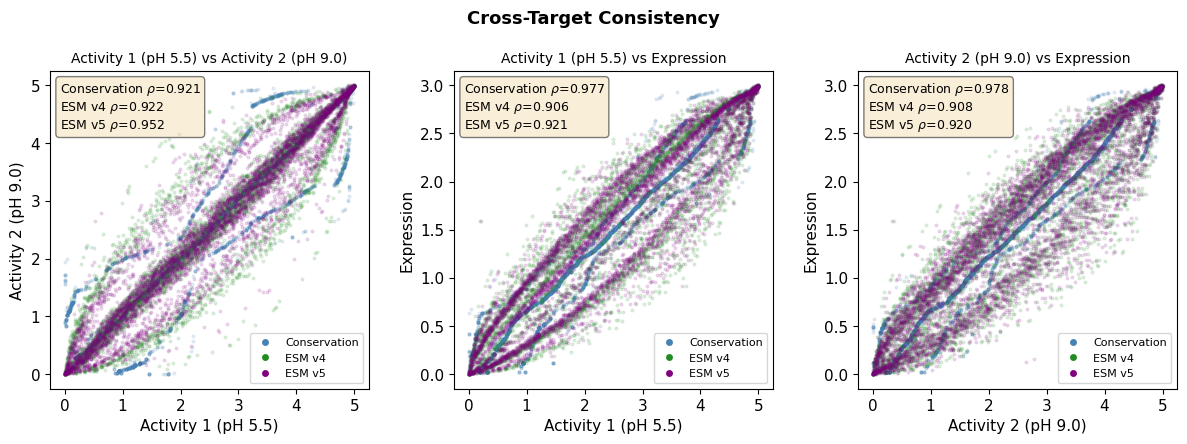

Saved: results/comparison_cross_target.png


In [13]:
color_map_ct = {'Conservation': 'steelblue', 'ESM v4': 'forestgreen', 'ESM v5': 'purple'}
pairs = [('act1', 'act2'), ('act1', 'expr'), ('act2', 'expr')]
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))

for idx, (k1, k2) in enumerate(pairs):
    ax = axes[idx]
    col1, col2 = TARGETS[k1], TARGETS[k2]

    legend_elems = []
    text_parts = []
    for name, df in submissions.items():
        s1, s2 = df[col1].values, df[col2].values
        c = color_map_ct.get(name, 'gray')
        ax.scatter(s1, s2, s=4, alpha=0.12, c=c, label=name)
        rho_val, _ = stats.spearmanr(s1, s2)
        text_parts.append(f"{name} $\\rho$={rho_val:.3f}")
        legend_elems.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
                                   markersize=6, label=name))

    ax.text(0.03, 0.97, '\n'.join(text_parts), transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.set_xlabel(TARGET_LABELS[k1])
    ax.set_ylabel(TARGET_LABELS[k2])
    ax.set_title(f'{TARGET_LABELS[k1]} vs {TARGET_LABELS[k2]}', fontsize=10)
    ax.legend(handles=legend_elems, fontsize=8, loc='lower right')

plt.suptitle('Cross-Target Consistency', fontsize=13, fontweight='bold')
plt.tight_layout(w_pad=2)
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_cross_target.png'), dpi=120, bbox_inches='tight')
plt.show()
print("Saved: results/comparison_cross_target.png")


## 5. Summary and Recommendation

Aggregate **prediction-quality metrics only** into a winner-per-criterion table. Practical considerations (compute cost, interpretability) are noted in prose but excluded from the scoring — they don't affect NDCG.


In [14]:
summary_rows = []

# Criterion 1: IsPETase zero-shot (Conservation only — ESM unavailable)
summary_rows.append({
    'Criterion': 'IsPETase zero-shot (10 mutants)',
    'Conservation': f'rho={rho:.3f} (direct)',
    'ESM': 'N/A (IsPETase not in test set)',
    'Winner': 'Conservation (only available)'
})

# Criterion 2: IsPETase ML proxy (FAIR — same protocol, same data)
summary_rows.append({
    'Criterion': 'IsPETase ML proxy (31 variants, LOOCV)',
    'Conservation': f'rho={cons_ml_rho:.3f} ({X_cons.shape[1]} features)',
    'ESM': f'rho={esm_rho:.3f} ({X_all.shape[1]} features)',
    'Winner': 'ESM' if esm_rho > cons_ml_rho else 'Conservation'
})

# Criterion 3: WT/mutant separation (average Cohen's d)
cons_d_avg = sep_df[sep_df['Approach'] == 'Conservation']['Cohen_d'].abs().mean()
esm_names = [k for k in submissions if k != 'Conservation']
if esm_names:
    esm_d_parts = []
    best_esm_d = 0
    for en in esm_names:
        d_avg = sep_df[sep_df['Approach'] == en]['Cohen_d'].abs().mean()
        esm_d_parts.append(f'{en}: {d_avg:.3f}')
        best_esm_d = max(best_esm_d, d_avg)
    summary_rows.append({
        'Criterion': 'WT/Mutant separation (avg |d|)',
        'Conservation': f'{cons_d_avg:.3f}',
        'ESM': ', '.join(esm_d_parts),
        'Winner': 'Conservation' if cons_d_avg > best_esm_d else esm_names[np.argmax([
            sep_df[sep_df['Approach'] == en]['Cohen_d'].abs().mean() for en in esm_names])]
    })

# Criterion 4: Score granularity (unique scores — critical for NDCG)
cons_unique = gran_df[gran_df['Approach'] == 'Conservation']['Unique Scores'].mean()
if esm_names:
    esm_unique_parts = []
    best_esm_unique = 0
    for en in esm_names:
        u = gran_df[gran_df['Approach'] == en]['Unique Scores'].mean()
        esm_unique_parts.append(f'{en}: {u:.0f}')
        best_esm_unique = max(best_esm_unique, u)
    summary_rows.append({
        'Criterion': 'Score granularity (avg unique scores)',
        'Conservation': f'{cons_unique:.0f}',
        'ESM': ', '.join(esm_unique_parts),
        'Winner': 'Conservation' if cons_unique > best_esm_unique else 'ESM'
    })

# Criterion 5: Within-scaffold discrimination
cons_within = gran_df[gran_df['Approach'] == 'Conservation']['Within-Scaffold Std'].mean()
if esm_names:
    esm_within_parts = []
    best_esm_within = 0
    for en in esm_names:
        w = gran_df[gran_df['Approach'] == en]['Within-Scaffold Std'].mean()
        esm_within_parts.append(f'{en}: {w:.4f}')
        best_esm_within = max(best_esm_within, w)
    summary_rows.append({
        'Criterion': 'Within-scaffold discrimination (avg std)',
        'Conservation': f'{cons_within:.4f}',
        'ESM': ', '.join(esm_within_parts),
        'Winner': 'Conservation' if cons_within > best_esm_within else 'ESM'
    })

summary = pd.DataFrame(summary_rows)
print("=" * 80)
print("APPROACH COMPARISON SUMMARY (prediction-quality metrics only)")
print("=" * 80)
print(summary.to_string(index=False))

# Count wins
cons_wins = sum(1 for r in summary_rows if 'Conservation' in r['Winner'] and 'ESM' not in r['Winner'])
esm_wins = sum(1 for r in summary_rows if 'ESM' in r['Winner'] and 'Conservation' not in r['Winner'])
ties = len(summary_rows) - cons_wins - esm_wins

print(f"\n--- Score: Conservation {cons_wins}, ESM {esm_wins}, N/A {ties} ---\n")

if cons_wins > esm_wins:
    rec = "Conservation"
    reason = ("Conservation scoring wins on more prediction-quality criteria. "
              "Recommended as primary submission.")
elif esm_wins > cons_wins:
    rec = "ESM v5"
    reason = ("ESM scoring wins on more prediction-quality criteria, particularly "
              "score granularity and within-scaffold discrimination — both critical for NDCG. "
              "Recommended as primary submission.")
else:
    rec = "Ensemble"
    reason = ("Results are tied. The ensemble at the optimal alpha blends Conservation's "
              "strong WT/mutant separation with ESM's fine-grained ranking. "
              "Recommended as primary submission.")

print(f"RECOMMENDATION: Submit **{rec}** as primary")
print(f"Rationale: {reason}")

# Practical notes (not scored)
print("\n--- Practical Considerations (not scored) ---")
print("  Compute: Conservation (CPU, ~1 min) vs ESM (A100 GPU, ~30 min)")
print("  Interpretability: Conservation (per-position) vs ESM (log-likelihood)")
print("  These don't affect NDCG and are excluded from the comparison scoring.")

if esm_available:
    print(f"\nEnsemble optimal alphas (Cohen's d x rank entropy):")
    for key, alpha in optimal_alphas.items():
        print(f"  {TARGET_LABELS[key]}: alpha = {alpha:.2f}")


APPROACH COMPARISON SUMMARY (prediction-quality metrics only)
                               Criterion           Conservation                            ESM                        Winner
         IsPETase zero-shot (10 mutants)     rho=0.646 (direct) N/A (IsPETase not in test set) Conservation (only available)
  IsPETase ML proxy (31 variants, LOOCV) rho=0.875 (4 features)        rho=0.961 (37 features)                           ESM
          WT/Mutant separation (avg |d|)                  1.591   ESM v4: 0.582, ESM v5: 0.588                  Conservation
   Score granularity (avg unique scores)                   1501     ESM v4: 4987, ESM v5: 4987                           ESM
Within-scaffold discrimination (avg std)                 1.2062 ESM v4: 1.1663, ESM v5: 1.1593                  Conservation

--- Score: Conservation 3, ESM 2, N/A 0 ---

RECOMMENDATION: Submit **Conservation** as primary
Rationale: Conservation scoring wins on more prediction-quality criteria. Recommended as pr